# Final Report

* Author : 楊右宇  
* Establish Date：2021.12.24  
* Last Modified Date：2021.01.06

# import library

In [201]:
import pandas as pd
import numpy as np
import math
import mplfinance as mpf
import talib
from talib import abstract

# Indicators

## 當日漲跌幅

In [202]:
def variation(_df):

    res = _df.copy(deep=True)
    
    res['variation'] = np.nan

    col_var = res.columns.get_loc('variation')
    col_close = _df.columns.get_loc('Close')
    
    for i in range(1, len(_df)):
        res.iloc[i, col_var] = \
            ((_df.iloc[i, col_close] - _df.iloc[i - 1, col_close]) \
                / _df.iloc[i - 1, col_close]) * 100

    return res

## Moving Average

In [203]:
def MA(_ticker, n_days=10, field='Close'):
    """ make the new colume names as <ma_@n_days>, the value 
        will be the @n_days average of the @Close price"""

    res = _ticker.copy(deep=True)
    if field == 'Volume':
        res['VMA_' + str(n_days)] = _ticker[field].rolling(n_days).mean()

    else:
        res['MA_' + str(n_days)] = _ticker[field].rolling(n_days).mean()

    return res

## EMA

emm 使用方式 : https://blog.csdn.net/The_Time_Runner/article/details/108209361

In [268]:
def EMA(_ticker, period=15):
    '''
        計算EMA，並新增在 DataFrame 中'''
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    # 新增新的一欄在 DataFrame 中
    res['EMA_' + str(period)] = _ticker['Close'].ewm(span=period, adjust=False).mean()

    return res

In [269]:
def TA_EMA(_ticker, n_days=15, field='Close'):
    '''
        使用 TA-lib 計算EMA'''
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
    # 呼叫函式
    ema_temp = talib.EMA(_ticker[field], n_days)
    # 將回傳值加入 DataFrame 中
    res['EMA_' + str(n_days)] = ema_temp

    return res

In [206]:
### 410921258 ###
#calculate EMA
def _ema(arr, i=None):
    N = len(arr)
    a = 2/(N+1) # indicator
    i =  N-1 if i is None else i 
    if i==0:
        return arr[i]
    else:
        data = 0
        data += (a*arr[i]+(1-a)*_ema(arr,i-1))#formula of resursion
        return data

## RSI

RSI(Relative Strength Index)相對強弱指標，如圖三公式，計算出一個0~100之間的數字，越接近０表示盤勢越弱，越容易下跌，越接近100表示盤勢越強，越容易上漲。其中ｎ代表往前抓多久的數據來計算RSI值，典型的參數值是６日RSI。

In [207]:
def RSI(_ticker, n_days = 14):
    
    # Create a empty dataFrame with original index
    # To store some temporary data
    tmp = pd.DataFrame(index=_ticker.index)

    # Copy a dataFrame to store result
    # deep=True means make a copy instead of link
    res = _ticker.copy(deep=True)

    tmp['rise'] = np.nan

    col_rise = tmp.columns.get_loc('rise')
    col_close = _ticker.columns.get_loc('Close')

    for i in range(1, len(_ticker)):
        tmp.iloc[i, col_rise] = (_ticker.iloc[i, col_close] - _ticker.iloc[i - 1, col_close])


    tmp['rise_only'] = tmp['rise']
    tmp['drop_only'] = tmp['rise']

    tmp['rise_only'].loc[tmp['rise'] < 0] = 0
    tmp['drop_only'].loc[tmp['rise'] > 0] = 0
    
    tmp['rise_avg'] = tmp['rise_only'].rolling(n_days).mean()
    tmp['drop_avg'] = tmp['drop_only'].rolling(n_days).mean().abs()

    res['RSI'] = tmp['rise_avg'] / (tmp['rise_avg'] + tmp['drop_avg']) * 100
    
    return res

## KD

以這樣的公式，會計算出每根Ｋ棒的Ｋ值與Ｄ值，配合Ｋ棒的發展形成Ｋ值線與Ｄ值線，Ｋ值比Ｄ值敏感，波動幅度較大，Ｋ值線如果在低檔區由下而上穿過Ｄ值線，則稱作黃金交叉，代表接下來盤勢上漲機會大，Ｋ值線如果在高檔區由上而下穿過Ｄ值線，稱作死亡交叉，代表接下來盤勢下跌的機會大

In [208]:
def KD(_ticker, n_days = 9):

    # Create a empty dataFrame with original index
    # To store some temporary data
    tmp = pd.DataFrame(index=_ticker.index)

    # Copy a dataFrame to store result
    # deep=True means make a copy instead of link
    res = _ticker.copy(deep=True)

    tmp['max_close'] = ticker['Close'].rolling(n_days).max()
    tmp['min_close'] = ticker['Close'].rolling(n_days).min()
    # tmp['max_close'] = ticker['Close'].rolling(n_days, min_periods=1).max()
    # tmp['min_close'] = ticker['Close'].rolling(n_days, min_periods=1).min()

    # RSV also called FastK
    tmp['RSV'] = (ticker['Close'] - tmp['min_close']) / (tmp['max_close'] - tmp['min_close']) * 100

    res['K'] = .0
    res['D'] = .0
    
    col_k = res.columns.get_loc('K')
    col_d = res.columns.get_loc('D')
    col_rsv = tmp.columns.get_loc('RSV')

    # for i in range(1, len(_ticker)):
    for i in range(9, len(_ticker)):
        res.iloc[i, col_k] = res.iloc[i - 1, col_k] * 2 / 3 + tmp.iloc[i, col_rsv] * 1 / 3
        res.iloc[i, col_d] = res.iloc[i - 1, col_d] * 2 / 3 + res.iloc[i, col_k] * 1 / 3
    
    return res

## MACD

TA-lib的macd函數計算macd值，函數輸出3個值，

macd（對應diff）

macdsignal（對應dea）

macdhist（對應macd）

In [209]:
def MACD(_ticker, _fastperiod=12, _slowperiod=26, _signalperiod=9):
    
    res = _ticker.copy(deep=True)

    ema_f = _ticker['Close'].ewm(span=_fastperiod, adjust=False).mean()
    ema_s = _ticker['Close'].ewm(span=_slowperiod, adjust=False).mean()
    res['macd_dif'] = ema_f - ema_s
    res['macd_dea'] = res['macd_dif'].ewm(span=_signalperiod, adjust=False).mean()
    res['macd'] = res['macd_dif'] - res['macd_dea']

    return res

In [210]:
def TA_MACD(_ticker, _fastperiod=12, _slowperiod=26, _signalperiod=9):
    
    res = _ticker.copy(deep=True)

    # use talib to calculate MACD
    prices = np.array(_ticker['Close'])
    macd_tmp = talib.MACD(prices, fastperiod=_fastperiod,
                          slowperiod=_slowperiod, signalperiod=_signalperiod)
    
    res['macd_dif'] = macd_tmp[0]
    res['macd_dea'] = macd_tmp[1]
    res['macd'] = macd_tmp[2]
    
    return res

## Bollinger Bands

In [270]:
def BBands(_ticker, period=20, std_num=2):
    
    res = _ticker.copy(deep=True)

    res['bbands_middle'] = _ticker['Close'].rolling(period).mean()
    
    # Calculate the Standard Deviation
    std = _ticker['Close'].rolling(period).std(ddof=0) 
    
    # Calculate top band
    res['bbands_upper'] = res['bbands_middle'] + std * std_num 
    # Calculate bottom band
    res['bbands_lower'] = res['bbands_middle'] - std * std_num

    return res

In [212]:
def TA_BBands(_ticker, period=20, std_num=2):
    
    res = _ticker.copy(deep=True)

    upper, middle, lower = talib.BBANDS(
                                _ticker['Close'], 
                                timeperiod=period,
                                nbdevup=std_num, # number of non-biased standard deviations from the mean
                                nbdevdn=std_num,
                                matype=0        # Moving average type: simple moving average here
                                )

    res['bbands_upper'] = upper
    res['bbands_middle'] = middle
    res['bbands_lower'] = lower

    return res

# 交易策略

## MA

In [213]:
# 買點 : 短中長期均線呈多方趨勢
# 賣點 : 股價跌破長期均線時

def ma_strategy(_ticker):

    
    res = _ticker.copy(deep=True)

    res['buy_point'] = 0
    col_b = res.columns.get_loc('buy_point')

    for i in range(1, len(_ticker)):
        if _ticker.loc[_ticker.index[i], 'ma_5'] > _ticker.loc[_ticker.index[i], "ma_10"] > _ticker.loc[_ticker.index[i], "ma_20"] \
            and (_ticker.loc[_ticker.index[i], 'ma_5'] - _ticker.loc[_ticker.index[i - 1], 'ma_5']) \
                / _ticker.loc[_ticker.index[i - 1], 'ma_5'] > 0.01 \
            and (_ticker.loc[_ticker.index[i], "ma_20"] - _ticker.loc[_ticker.index[i - 1], "ma_20"]) \
                / _ticker.loc[_ticker.index[i - 1], "ma_20"] > 0.007 :

            res.iloc[i, col_b] = 1

        elif _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'ma_20']:
            res.iloc[i, col_b] = -1
            
    return res

## RSI

In [214]:
# RSI 買賣超

def rsi_bound(_ticker):
    
    upperbound = 95
    lowerbound = 15
    
    res = _ticker.copy(deep=True)
    res['buy_point'] = 0
    col_b = res.columns.get_loc('buy_point')

    for i in range(len(_ticker)):
        if(_ticker['RSI'][i] < lowerbound):
            res.iloc[i, col_b] = 1

        elif(_ticker['RSI'][i] > upperbound):
            res.iloc[i, col_b] = -1
            
    return res

## KD

In [215]:
### 410974045 ###
def kd_strategy(_ticker):
    ## 當KD值位於20下方向上做黃金交叉時買進，反之處於80上方向下做死亡交叉時賣出
    
    res = _ticker.copy(deep=True)
    res['buy_point'] = 0
    col_b = res.columns.get_loc('buy_point')

    for i in range(1, len(_ticker)):
        if _ticker.loc[_ticker.index[i-1], 'K'] < 20 and _ticker.loc[_ticker.index[i-1], 'D'] < 20 \
           and _ticker.loc[_ticker.index[i], 'K'] > _ticker.loc[_ticker.index[i], 'D'] \
           and _ticker.loc[_ticker.index[i-1], 'K'] < _ticker.loc[_ticker.index[i-1], 'D'] :
            res.iloc[i, col_b] = 1
        elif _ticker.loc[_ticker.index[i-1], 'K'] > 80 and _ticker.loc[_ticker.index[i-1], 'D'] > 80 \
           and _ticker.loc[_ticker.index[i], 'K'] < _ticker.loc[_ticker.index[i], 'D'] \
           and _ticker.loc[_ticker.index[i-1], 'K'] > _ticker.loc[_ticker.index[i-1], 'D'] :
            res.iloc[i, col_b] = -1
            
    return res

## MACD 策略

1.DIFF、DEA均為正，DIFF向上突破DEA，買入信號。

2.DIFF、DEA均為負，DIFF向下跌破DEA，賣出信號。

3.DEA線與K線發生背離，行情反轉信號。

4.分析MACD柱狀線，由正變負，賣出信號；由負變正，買入信號。

In [216]:
def macd_rule_1(_ticker):

    try:
        if not {'macd_dif', 'macd_dea', 'macd'}.issubset(_ticker.columns):
            _ticker = MACD(_ticker)
    except Exception as e:
        print(e)
        return False
    
    res = _ticker.copy(deep=True)
    res['buy_point'] = 0

    for i in range(1, len(_ticker)):
        if (_ticker.loc[_ticker.index[i], 'macd_dif'] > _ticker.loc[_ticker.index[i], 'macd_dea']) \
            and ((_ticker.loc[_ticker.index[i - 1], 'macd_dea'] > _ticker.loc[_ticker.index[i - 1], 'macd_dif'])
            or (abs(_ticker.loc[_ticker.index[i - 1], 'macd_dea'] - _ticker.loc[_ticker.index[i - 1], 'macd_dif']) < 0.007)) :

            res.loc[res.index[i], 'buy_point'] = 1

        elif _ticker.loc[_ticker.index[i], 'macd_dif'] < _ticker.loc[_ticker.index[i], 'macd_dea'] \
             and _ticker.loc[_ticker.index[i - 1], 'macd_dea'] > _ticker.loc[_ticker.index[i - 1], 'macd_dif']:

            res.loc[res.index[i], 'buy_point'] = -1

    return res

## MACD+RSI+KD

* 買入 : macd 黃金交叉 + KD沒買超 + RSI > 50
* 賣出 : KD 進入超買區，且 D 值正在往下

因為macd 遇到股價震盪時容易失效，所以以RSI指標去確定此時股價的趨勢為向上，但為了不希望遇到的時機是上漲的末端，所以同時檢測KD是否超買。

In [258]:
def muti_indi_rule_1(_ticker, buy_point_name='buy_point'):
    try:
        if not {'macd_dif', 'macd_dea', 'macd'}.issubset(_ticker.columns):
            _ticker = MACD(_ticker)
        if not {'K', 'D'}.issubset(_ticker.columns):
            _ticker = KD(_ticker)
        if not {'RSI'}.issubset(_ticker.columns):
            _ticker = RSI(_ticker)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    for i in range(1, len(_ticker)):
        if (_ticker.loc[_ticker.index[i], 'macd_dif'] > _ticker.loc[_ticker.index[i], 'macd_dea']) and \
            (_ticker.loc[_ticker.index[i - 1], 'macd_dea'] > _ticker.loc[_ticker.index[i - 1], 'macd_dif']) and \
            (_ticker.loc[_ticker.index[i], 'RSI'] > 60) and \
            (_ticker.loc[_ticker.index[i], 'K'] < 85 and _ticker.loc[_ticker.index[i], 'D'] < 85):

            res.loc[res.index[i], 'buy_point'] = 1

        # elif _ticker.loc[_ticker.index[i], 'K'] > 85 and _ticker.loc[_ticker.index[i], 'D'] > 85 \
        #     and _ticker.loc[_ticker.index[i], 'D'] < _ticker.loc[_ticker.index[i - 1], 'D']:

        #     res.loc[res.index[i], 'buy_point'] = -1

    return res

## KD + RSI

當KD發生黃金交叉，同時RSI也大於某一數值時，就做多。相反的，當KD死亡交叉，同時RSI也小於某一數值時，就做空。

In [217]:
def muti_indi_rule_2(_ticker, buy_point_name='buy_point', rsi_buy_point=60, rsi_sell_point=40):
    
    try:
        if not {'K', 'D'}.issubset(_ticker.columns):
            _ticker = KD(_ticker)
        if not {'RSI'}.issubset(_ticker.columns):
            _ticker = RSI(_ticker)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    for i in range(1, len(_ticker)):
        if _ticker.loc[_ticker.index[i], 'K'] > _ticker.loc[_ticker.index[i], 'D'] \
            and _ticker.loc[_ticker.index[i - 1], 'K'] < _ticker.loc[_ticker.index[i - 1], 'D'] \
            and _ticker.loc[_ticker.index[i], 'RSI'] > rsi_buy_point:

            res.loc[res.index[i], 'buy_point'] = 1

        elif _ticker.loc[_ticker.index[i], 'K'] < _ticker.loc[_ticker.index[i], 'D'] \
            and _ticker.loc[_ticker.index[i - 1], 'K'] > _ticker.loc[_ticker.index[i - 1], 'D'] \
            and _ticker.loc[_ticker.index[i], 'RSI'] < rsi_sell_point:

            res.loc[res.index[i], 'buy_point'] = -1

    return res

## MACD + RSI

* 買入 : macd 在小於零時黃金交叉 + RSI < 50
* 賣出 : 

In [218]:
def muti_indi_rule_3(_ticker, buy_point_name='buy_point'):
    try:
        if not {'macd_dif', 'macd_dea', 'macd'}.issubset(_ticker.columns):
            _ticker = MACD(_ticker)
        if not {'RSI'}.issubset(_ticker.columns):
            _ticker = RSI(_ticker)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    for i in range(1, len(_ticker)):
        if (_ticker.loc[_ticker.index[i], 'macd_dif'] > _ticker.loc[_ticker.index[i], 'macd_dea']) and \
            (_ticker.loc[_ticker.index[i - 1], 'macd_dea'] > _ticker.loc[_ticker.index[i - 1], 'macd_dif']) and \
            (_ticker.loc[_ticker.index[i], 'RSI'] < 50) and \
            (_ticker.loc[_ticker.index[i], 'macd_dif'] < 0):

            res.loc[res.index[i], 'buy_point'] = 1

        # elif (_ticker.loc[_ticker.index[i], 'macd_dea'] > _ticker.loc[_ticker.index[i], 'macd_dif']) and \
        #     (_ticker.loc[_ticker.index[i - 1], 'macd_dif'] > _ticker.loc[_ticker.index[i - 1], 'macd_dea']) and \
        #     (_ticker.loc[_ticker.index[i], 'RSI'] > 50) and \
        #     (_ticker.loc[_ticker.index[i], 'macd_dif'] > 0):

        #     res.loc[res.index[i], 'buy_point'] = -1

    return res

## MACD + 成交量

MACD柱狀斜率向上5天 4.KD黃金交叉 者(過濾成交量<500)

## MACD + Bbands

In [256]:
def muti_indi_rule_4(_ticker, buy_point_name='buy_point', kd_buy_point=25):
    
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(_ticker.columns):
            _ticker = BBands(_ticker)
        if not {'macd_dif', 'macd_dea', 'macd'}.issubset(_ticker.columns):
            _ticker = MACD(_ticker)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    for i in range(1, len(_ticker)):
        if _ticker.loc[_ticker.index[i], 'macd_dif'] > _ticker.loc[_ticker.index[i], 'macd_dea'] and \
            _ticker.loc[_ticker.index[i - 1], 'macd_dea'] > _ticker.loc[_ticker.index[i - 1], 'macd_dif'] \
            and _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'bbands_middle']:

            res.loc[res.index[i], 'buy_point'] = 1

        # elif _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'bbands_upper'] \
        #     and _ticker.loc[_ticker.index[i - 1], 'Close'] > _ticker.loc[_ticker.index[i - 1], 'bbands_upper']:

        #     res.loc[res.index[i], 'buy_point'] = -1

    return res

## KD + Bbands

* 買進信號：KD在低檔（小於25）金叉，且收盤價仍在布林通道中線以下時。
* 賣出信號：昨日收盤價仍在布林通道上緣，今日收盤價卻跌落布林通道上緣時。

In [247]:
def muti_indi_rule_5(_ticker, buy_point_name='buy_point', kd_buy_point=25):
    
    try:
        if not {'K', 'D'}.issubset(_ticker.columns):
            _ticker = KD(_ticker)
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(_ticker.columns):
            _ticker = BBands(_ticker)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    for i in range(1, len(_ticker)):
        if _ticker.loc[_ticker.index[i], 'K'] > _ticker.loc[_ticker.index[i], 'D'] \
            and _ticker.loc[_ticker.index[i - 1], 'K'] < _ticker.loc[_ticker.index[i - 1], 'D'] \
            and _ticker.loc[_ticker.index[i], 'K'] < kd_buy_point:
            # and _ticker.loc[_ticker.index[i], 'Close'] > _ticker.loc[_ticker.index[i], 'bbands_middle']:

            res.loc[res.index[i], 'buy_point'] = 1

        # elif _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'bbands_upper'] \
        #     and _ticker.loc[_ticker.index[i - 1], 'Close'] > _ticker.loc[_ticker.index[i - 1], 'bbands_upper']:

        #     res.loc[res.index[i], 'buy_point'] = -1

    return res

In [263]:
def muti_indi_rule_6(_ticker, buy_point_name='buy_point', kd_buy_point=25):
    
    try:
        if not {'K', 'D'}.issubset(_ticker.columns):
            _ticker = KD(_ticker)
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(_ticker.columns):
            _ticker = BBands(_ticker)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    for i in range(1, len(_ticker)):
        if _ticker.loc[_ticker.index[i], 'K'] > _ticker.loc[_ticker.index[i], 'D'] \
            and _ticker.loc[_ticker.index[i - 1], 'K'] < _ticker.loc[_ticker.index[i - 1], 'D'] \
            and _ticker.loc[_ticker.index[i], 'macd_dif'] > _ticker.loc[_ticker.index[i], 'macd_dea'] \
            and _ticker.loc[_ticker.index[i - 1], 'macd_dea'] > _ticker.loc[_ticker.index[i - 1], 'macd_dif']:
            # and _ticker.loc[_ticker.index[i], 'Close'] > _ticker.loc[_ticker.index[i], 'bbands_middle']:

            res.loc[res.index[i], 'buy_point'] = 1

        # elif _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'bbands_upper'] \
        #     and _ticker.loc[_ticker.index[i - 1], 'Close'] > _ticker.loc[_ticker.index[i - 1], 'bbands_upper']:

        #     res.loc[res.index[i], 'buy_point'] = -1

    return res

## KD + RSI
* 多 : KD 黃金交叉，且 RSI 也大於某一數值
* 空 : KD 死亡交叉，且 RSI 也小於某一數值

In [ ]:
def kd_rsi_rule(_ticker, buy_point_name='buy_point', rsi_buy_point=60, rsi_sell_point=40):
    
    try:
        if not {'K', 'D'}.issubset(_ticker.columns):
            _ticker = KD(_ticker)
        if not {'RSI'}.issubset(_ticker.columns):
            _ticker = RSI(_ticker)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    for i in range(1, len(_ticker)):
        if _ticker.loc[_ticker.index[i], 'K'] > _ticker.loc[_ticker.index[i], 'D'] \
            and _ticker.loc[_ticker.index[i - 1], 'K'] < _ticker.loc[_ticker.index[i - 1], 'D'] \
            and _ticker.loc[_ticker.index[i], 'RSI'] > rsi_buy_point:

            res.loc[res.index[i], 'buy_point'] = 1

        elif _ticker.loc[_ticker.index[i], 'K'] < _ticker.loc[_ticker.index[i], 'D'] \
            and _ticker.loc[_ticker.index[i - 1], 'K'] > _ticker.loc[_ticker.index[i - 1], 'D'] \
            and _ticker.loc[_ticker.index[i], 'RSI'] < rsi_sell_point:

            res.loc[res.index[i], 'buy_point'] = -1

    return res

## BBands + EMA + RSI

* 多 : 布林帶撞破下軌後，爬回均線，且RSI低於一定值
* 空 : 布林帶撞破上軌後，跌回均線，且RSI高於一定值

In [ ]:
def bbands_ema_rsi_rule(_ticker, buy_point_name='buy_point', rsi_buy_point=50, rsi_sell_point=50, ma_period=5):
    
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(_ticker.columns):
            _ticker = BBands(_ticker)
        if not {'RSI'}.issubset(_ticker.columns):
            _ticker = RSI(_ticker)
        if not {'EMA_' + str(ma_period)}.issubset(_ticker.columns):
            _ticker = EMA(_ticker, ma_period)
    except Exception as e:
        print(e)
        return False

    res = _ticker.copy(deep=True)
    res[buy_point_name] = 0

    is_lower = False
    is_upper = False

    for i in range(1, len(_ticker)):

        if _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'bbands_lower']:
            is_lower = True
        elif _ticker.loc[_ticker.index[i], 'Close'] > _ticker.loc[_ticker.index[i], 'bbands_middle']:
            is_lower = False
        
        if _ticker.loc[_ticker.index[i], 'Close'] > _ticker.loc[_ticker.index[i], 'bbands_upper']:
            is_upper = True
        elif _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'bbands_middle']:
            is_upper = False
        
        
        if is_lower and _ticker.loc[_ticker.index[i], 'Close'] > _ticker.loc[_ticker.index[i], 'EMA_' + str(ma_period)] \
            and _ticker.loc[_ticker.index[i], 'RSI'] < rsi_buy_point:
            
            res.loc[res.index[i], 'buy_point'] = 1
        
        elif is_upper and _ticker.loc[_ticker.index[i], 'Close'] < _ticker.loc[_ticker.index[i], 'EMA_' + str(ma_period)] \
            and _ticker.loc[_ticker.index[i], 'RSI'] > rsi_sell_point:
            
            res.loc[res.index[i], 'buy_point'] = -1

    return res

# 繪圖

## RSI

In [222]:
def plot_rsi(_ticker, _title='', upper_bound=85, lower_bound=15, bound_line=True, middle_line=True):

    # Add the RSI indicator to plot
    apds = [ 
        mpf.make_addplot(_ticker['RSI'], panel = 1, color='#c8d164', title='RSI')
    ]

    # Add upperbound & lowerbound to plot
    if bound_line:
        apds += [
            mpf.make_addplot(np.full((len(_ticker)), upper_bound), 
                panel = 1, color='#bf5ce0', alpha=0.5, secondary_y=False),
            mpf.make_addplot(np.full((len(_ticker)), lower_bound), 
                panel = 1, color='#7e3696', alpha=0.5, secondary_y=False)
        ]

    # Add middleLine to plot
    if middle_line:
        apds += [mpf.make_addplot(np.full((len(_ticker)), 50), 
                panel = 1, color='#8eff75', alpha=0.5)]


    # 設置k線圖顏色
    my_color = mpf.make_marketcolors(up='red',  # 上漲
                                     down='green',  # 下跌
                                     edge='i',  # 隱藏K線邊緣
                                     volume='in',  # 成交量用同樣的顏色
                                     inherit=True)

    my_style = mpf.make_mpf_style(gridaxis='both',  # 設置網格
                                  gridstyle='-.',
                                  y_on_right=True,
                                  marketcolors=my_color)

    mpf.plot(_ticker, 
        type='candle', 
        volume=True, 
        volume_panel=2,
        addplot = apds,
        figratio=(18, 10), 
        figscale=1.2,
        panel_ratios=(6,3,2), 
        style=my_style,
        title=_title, 
        show_nontrading=False,
        tight_layout=False
        )

    return

## KD

In [223]:
def plot_kd(_ticker, _title='', upper_bound=80, lower_bound=20, bound_line=True):

    # Add the KD indicator to plot
    apds = [ 
        #     '#c8d164' is yellow
        #     '#7dc2fa' is blue
        mpf.make_addplot(_ticker['K'], panel = 1, color='#c8d164', 
            title='K(yellow), D(blue)'),
        mpf.make_addplot(_ticker['D'], panel = 1, color='#7dc2fa'),
        ]

    # Add upperbound & lowerbound to plot
    if bound_line:
        apds += [
            mpf.make_addplot(np.full((len(_ticker)), upper_bound), 
                panel = 1, color='#bf5ce0', alpha=0.5, secondary_y=False),
            mpf.make_addplot(np.full((len(_ticker)), lower_bound), 
                panel = 1, color='#7e3696', alpha=0.5, secondary_y=False)
        ]

    # 設置k線圖顏色
    my_color = mpf.make_marketcolors(up='red',  # 上漲
                                     down='green',  # 下跌
                                     edge='i',  # 隱藏K線邊緣
                                     volume='in',  # 成交量用同樣的顏色
                                     inherit=True)

    my_style = mpf.make_mpf_style(gridaxis='both',  # 設置網格
                                  gridstyle='-.',
                                  y_on_right=True,
                                  marketcolors=my_color)

    mpf.plot(_ticker, 
        type='candle', 
        volume=True, 
        volume_panel=2,
        addplot = apds,
        figratio=(18, 10), 
        figscale=1.2,
        panel_ratios=(6,3,2), 
        style=my_style,
        title=_title, 
        show_nontrading=False,
        tight_layout=False
        )
    return

## MACD

In [224]:
def plot_macd(_ticker, _title=''):

    # Add MACD indicator to plot
    apds = [
        # mpf.make_addplot(_ticker['macd_ema_f'],color='lime'),
        # mpf.make_addplot(_ticker['macd_ema_s'],color='c'),
        mpf.make_addplot(_ticker['macd'], type='bar', width=0.7, panel=1,
            color='dimgray', alpha=1, secondary_y=False),
        mpf.make_addplot(_ticker['macd_dif'], panel=1, color='fuchsia', secondary_y=True),
        mpf.make_addplot(_ticker['macd_dea'], panel=1, color='b', secondary_y=True),
    ]

    # 設置k線圖顏色
    my_color = mpf.make_marketcolors(up='red',  # 上漲
                                     down='green',  # 下跌
                                     edge='i',  # 隱藏K線邊緣
                                     volume='in',  # 成交量用同樣的顏色
                                     inherit=True)

    my_style = mpf.make_mpf_style(gridaxis='both',  # 設置網格
                                  gridstyle='-.',
                                  y_on_right=True,
                                  marketcolors=my_color)

    mpf.plot(_ticker, 
        type='candle', 
        volume=True, 
        volume_panel=2,
        addplot = apds,
        figratio=(18, 10), 
        figscale=1.2,
        panel_ratios=(6, 3, 2), 
        style=my_style,
        title=_title, 
        show_nontrading=False,
        tight_layout=False
        )
    return

## MUTI_PLOT

In [260]:
def plot_muti(_ticker, _title='', volume=True, buy_sell_point=False, 
    RSI=False, rsi_midline=False, rsi_bound=False, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=False, BBands=False):

    apds = []
    _panel = 1

    # Add the buy point and sell point to plot
    if buy_sell_point:
        
        buy, sell = [np.nan], [np.nan]
        buy_b = False
        sell_b = False

        # Adjust the position to avoid signals block the lines
        for i in range(1, len(_ticker)):
            if _ticker.loc[_ticker.index[i], 'ticker_num'] > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                    
                buy.append(_ticker.loc[_ticker.index[i], 'High'] * 1.01)
                buy_b = True
            else:
                buy.append(np.nan)
            if _ticker.loc[_ticker.index[i], 'ticker_num'] < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                
                sell.append(_ticker.loc[_ticker.index[i], 'Low'] * 0.99)
                sell_b = True
            else:
                sell.append(np.nan)
        if sell_b:
            apds += [ 
                mpf.make_addplot(sell, panel=0, type = 'scatter', color = 'green', marker = '^', markersize = 100),
            ]
        if buy_b:
            apds += [ 
            mpf.make_addplot(buy, panel=0, type = 'scatter', color = 'red', marker = 'v', markersize = 100)
            ]



    # Add the RSI indicator to plot
    if RSI:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['RSI'], panel = _panel - 1, color='#c8d164', title='RSI', ylim=(0, 100), secondary_y=False)
        ]

        # Add upperbound & lowerbound to plot
        if rsi_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), rsi_lower_bound), 
                    panel = _panel - 1, color='#bf5ce0', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), rsi_upper_bound), 
                    panel = _panel - 1, color='#7e3696', alpha=0.5, secondary_y=False)
            ]

        # Add middleLine to plot
        if rsi_midline:
            apds += [mpf.make_addplot(np.full((len(_ticker)), 50), 
                    panel = _panel - 1, color='#743A3A', alpha=0.5)]

    # Add the KD indicator to plot
    if KD:

        _panel += 1
        apds += [ 
            #     '#c8d164' is yellow
            #     '#7dc2fa' is blue
            mpf.make_addplot(_ticker['K'], panel=_panel - 1, color='#c8d164', 
                title='K(yellow), D(blue)'),
            mpf.make_addplot(_ticker['D'], panel=_panel - 1, color='#7dc2fa'),
            ]

        # Add upperbound & lowerbound to plot
        if kd_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), kd_upper_bound), 
                    panel=_panel - 1, color='#bf5ce0', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), kd_lower_bound), 
                    panel=_panel - 1, color='#7e3696', alpha=0.5, secondary_y=False)
            ]

    # Add MACD indicator to plot
    if MACD:

        _panel += 1
        apds += [
            mpf.make_addplot(_ticker['macd'], type='bar', width=0.7, panel=_panel - 1,
                color='dimgray', alpha=1, secondary_y=False),
            mpf.make_addplot(_ticker['macd_dif'], panel=_panel - 1, color='fuchsia', secondary_y=True),
            mpf.make_addplot(_ticker['macd_dea'], panel=_panel - 1, color='b', secondary_y=True)
        ]

    if volume:
        _panel += 1

    if BBands:
        apds += [
            mpf.make_addplot(_ticker['bbands_middle'], panel=0, color='#9F4D95', alpha=1, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_upper'], panel=0, color='#0000C6', alpha=1, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_lower'], panel=0, color='#0000C6', alpha=1, secondary_y=False),
           
        ]

    # 設置k線圖顏色
    my_color = mpf.make_marketcolors(up='red',  # 上漲
                                     down='green',  # 下跌
                                     edge='i',  # 隱藏K線邊緣
                                     volume='in',  # 成交量用同樣的顏色
                                     inherit=True)

    my_style = mpf.make_mpf_style(gridaxis='both',  # 設置網格
                                  gridstyle='-.',
                                  y_on_right=True,
                                  marketcolors=my_color)

    mpf.plot(_ticker, 
        type='candle',
        num_panels=_panel,
        main_panel=0, 
        volume=volume, 
        volume_panel=_panel - 1,
        addplot = apds,
        # figratio=(18, 15), 
        figscale=1.5,
        # panel_ratios=(6, 3, 3, 2), 
        style=my_style,
        title=_title, 
        show_nontrading=False,
        tight_layout=False
        )
    return

# 資料讀取

In [226]:
def read_ticker(_ticker_code):
    
    try:
        res = pd.read_csv('C:\Coding\\43_School_S3\investment\\0_final_project\data\{}.csv'.format(str(_ticker_code)), 
            index_col=0, parse_dates=True)
    except Exception as e:
        print(e)
        return False

    return res

In [227]:
# # 檔案無欄位名稱時，加 -> names =  ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
# # df = pd.read_csv(r"C:\Coding\43_School_S3\investment\week14_RSI_KD\RSI\0050.csv", index_col=0, parse_dates=True)

# ticker = pd.read_csv(r"C:\Coding\10_VIP\data\2609.csv")

# # change the name of columns
# ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# # set the column "Date" to index
# ticker = ticker.set_index('Date')

# # set index column("Date") from string to datetime.datetime
# ticker.index = pd.to_datetime(ticker.index)

# # sort index column("Date") chronologically
# ticker = ticker.sort_index()

# 資料回測

### V1

* 根據策略中的買賣點來操作
* 會根據資金買入可買之最大張數

In [228]:
def back_track_v1(_ticker):

    funds = 1_000_000

    res = pd.DataFrame(index=_ticker.index)

    res['ticker_num'] = 0
    res['income'] = 0
    res['expenditure'] = 0
    res['account'] = funds


    for i in range(1, len(_ticker)):
        
        # 買入點
        if i != len(_ticker) - 1 and _ticker.loc[_ticker.index[i - 1], 'buy_point'] == 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] == 0 :
            
            res.loc[_ticker.index[i], 'ticker_num'] \
                = math.floor(res.loc[_ticker.index[i - 1], 'account'] / (_ticker.loc[_ticker.index[i], 'Open'] * 1.001425 * 1000))
            res.loc[_ticker.index[i], 'expenditure'] \
                = -res.loc[_ticker.index[i], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 1.001425 * 1000)
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'expenditure']
        
        # 賣出點
        elif _ticker.loc[_ticker.index[i - 1], 'buy_point'] == -1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 :
            
            # print(_ticker.index[i])
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        # 最後一天無條件賣出
        elif i == len(_ticker) - 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 :
            
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        else :
            
            res.loc[_ticker.index[i], 'ticker_num'] = res.loc[_ticker.index[i - 1], 'ticker_num']
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account']

    return res

### V2

* 加入停損，以買入點為基礎，往後股價高於或低於特定比例即賣出

In [229]:
def back_track_v2(_ticker, funds=1_000_000):

    res = pd.DataFrame(index=_ticker.index)

    res['ticker_num'] = 0
    res['income'] = 0
    res['expenditure'] = 0
    res['account'] = funds

    stop_loss = 0
    take_profit = 0

    for i in range(1, len(_ticker)):
        
        # 買入點
        if i != len(_ticker) - 1 and _ticker.loc[_ticker.index[i - 1], 'buy_point'] == 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] == 0 :
            
            res.loc[_ticker.index[i], 'ticker_num'] \
                = math.floor(res.loc[_ticker.index[i - 1], 'account'] / (_ticker.loc[_ticker.index[i], 'Open'] * 1.001425 * 1000))
            res.loc[_ticker.index[i], 'expenditure'] \
                = -res.loc[_ticker.index[i], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 1.001425 * 1000)
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'expenditure']
            stop_loss = _ticker.loc[_ticker.index[i], 'Open'] * 0.97
            take_profit = _ticker.loc[_ticker.index[i], 'Open'] * 1.1
        
        # 賣出點
        elif _ticker.loc[_ticker.index[i - 1], 'buy_point'] == -1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 :
            
            # print(_ticker.index[i])
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        # 停損點賣出
        elif res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 and (_ticker.loc[_ticker.index[i - 1], 'Close'] < stop_loss \
            or _ticker.loc[_ticker.index[i], 'Open'] < stop_loss \
            and _ticker.loc[_ticker.index[i], 'High'] > _ticker.loc[_ticker.index[i], 'Open']):

            # print('stoploss')
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        # 停利點賣出
        elif res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 and (_ticker.loc[_ticker.index[i - 1], 'Close'] > take_profit \
            or _ticker.loc[_ticker.index[i], 'Open'] > take_profit \
            and _ticker.loc[_ticker.index[i], 'High'] > _ticker.loc[_ticker.index[i], 'Open']):

            # print('takeprofit')
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        # 最後一天無條件賣出
        elif i == len(_ticker) - 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 :
            
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        else :
            
            res.loc[_ticker.index[i], 'ticker_num'] = res.loc[_ticker.index[i - 1], 'ticker_num']
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account']

    return res

### V3

* 移動停損停利
* 買入指標出現後，隔日進行買入
* 只買入整張

In [230]:
def back_track_v3(_ticker, funds=1_000_000, stop_percent=0.96):

    res = pd.DataFrame(index=_ticker.index)

    res['ticker_num'] = 0
    res['income'] = 0
    res['expenditure'] = 0
    res['account'] = funds

    stop_loss = 0

    for i in range(1, len(_ticker)):
        
        # 買入點
        if i != len(_ticker) - 1 and _ticker.loc[_ticker.index[i - 1], 'buy_point'] == 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] == 0 :
            
            res.loc[_ticker.index[i], 'ticker_num'] \
                = math.floor(res.loc[_ticker.index[i - 1], 'account'] / (_ticker.loc[_ticker.index[i], 'Open'] * 1.001425 * 1000))
            res.loc[_ticker.index[i], 'expenditure'] \
                = -res.loc[_ticker.index[i], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 1.001425 * 1000)
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'expenditure']
            stop_loss = _ticker.loc[_ticker.index[i], 'Open'] * stop_percent
        
        # 賣出點
        elif _ticker.loc[_ticker.index[i - 1], 'buy_point'] == -1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 :
            
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        # 停損停利點賣出
        elif res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 and (_ticker.loc[_ticker.index[i - 1], 'Close'] < stop_loss \
            or _ticker.loc[_ticker.index[i], 'Open'] < stop_loss \
            and _ticker.loc[_ticker.index[i], 'High'] > _ticker.loc[_ticker.index[i], 'Open']):

            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        # 最後一天無條件賣出
        elif i == len(_ticker) - 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0 :
            
            res.loc[_ticker.index[i], 'income'] \
                = res.loc[_ticker.index[i - 1], 'ticker_num'] * (_ticker.loc[_ticker.index[i], 'Open'] * 0.995575 * 1000)
            res.loc[_ticker.index[i], 'ticker_num'] = 0
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account'] + res.loc[_ticker.index[i], 'income']
        
        else :
            
            res.loc[_ticker.index[i], 'ticker_num'] = res.loc[_ticker.index[i - 1], 'ticker_num']
            res.loc[_ticker.index[i], 'account'] = res.loc[_ticker.index[i - 1], 'account']
            # update the stop_loss price
            if _ticker.loc[_ticker.index[i], 'Close'] * stop_percent > stop_loss:
                stop_loss = _ticker.loc[_ticker.index[i], 'Close'] * stop_percent

    return res

# 資料整理

In [231]:
def get_trade_info(_ticker):

    #紀錄交易資訊
    detail = []

    #暫時交易資訊
    temp_detail = []
    buy_price = 0
    funds = _ticker.loc[_ticker.index[0], 'account']

    for i in range(1, len(_ticker)):

        # buy info
        if _ticker.loc[_ticker.index[i], 'ticker_num'] \
            > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                    
            #交易資訊
            temp_detail.append(_ticker.index[i])
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Open'])
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Open'] \
                * 0.001425 * 1000 * _ticker.loc[_ticker.index[i], 'ticker_num'])     
            temp_detail.append(_ticker.loc[_ticker.index[i], 'expenditure'])
            temp_detail.append(np.nan)
            buy_price = _ticker.loc[_ticker.index[i], 'expenditure']
            temp_detail.append(np.nan)
            temp_detail.append(np.nan)
            temp_detail.append(np.nan)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])

            detail.append(temp_detail)
            temp_detail = []

        # sell info
        elif _ticker.loc[_ticker.index[i], 'ticker_num'] \
            < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
            
            # 交易資訊
            temp_detail.append(_ticker.index[i])
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Open'])
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Open'] \
                * 0.004425 * 1000 * _ticker.loc[_ticker.index[i - 1], 'ticker_num'])     
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'])
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'] + buy_price)
            temp_detail.append((_ticker.loc[_ticker.index[i], 'income'] + buy_price) / (-buy_price) * 100)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'] - funds)
            temp_detail.append((_ticker.loc[_ticker.index[i], 'account'] - funds) / funds * 100)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])

            detail.append(temp_detail)
            temp_detail = []
            

    return pd.DataFrame(detail, columns=['Date', 'ticker_num', 'price', 'tax', 
        'spend', 'profit', 'profit_rate', 'earn', 'earn_rate', 'account'])

## 計算總交易結論數據

In [232]:
def get_result(_df):
    # 買賣次數  贏 輸 勝率 報酬率

    win = 0
    loss = 0
    
    for i in range(1, len(_df), 2):
        if _df.loc[_df.index[i], 'profit_rate'] > 0:
            win += 1
        else :
            loss += 1

    if win + loss == 0:
        return [win + loss, win, loss, 0, 0]
    return [win + loss, win, loss, win / (win + loss), _df.loc[_df.index[len(_df) - 1], 'earn_rate']]

# 實作

In [233]:
# ticker_list = ['2303', '2308', '2317', '2330', '2409', '2454', '2609', '3481', '5351']
# strategy_list = [bound, ma_strategy, macd_rule_1]

# df_result = pd.DataFrame(columns=strategy_list)

# for data in ticker_list:

#     print(data)

#     ticker = read_ticker(data)
    
#     ticker = MA(ticker, 5)
#     ticker = MA(ticker, 10)
#     ticker = MA(ticker, 20)
#     ticker = variation(ticker)
#     ticker = RSI(ticker)
#     ticker = KD(ticker)
#     # ticker = TA_MACD(ticker)
#     ticker = MACD(ticker)

#     ticker = ticker.loc['2021':'2022', ]

#     for i in range(len(strategy_list)):

#         res = strategy_list[i](ticker)
#         print(strategy_list[i].__name__)
#         info = print_info(res)
#         print(info)


#         # df_result.loc[data, strategy_list[i].__name__] = 



0050


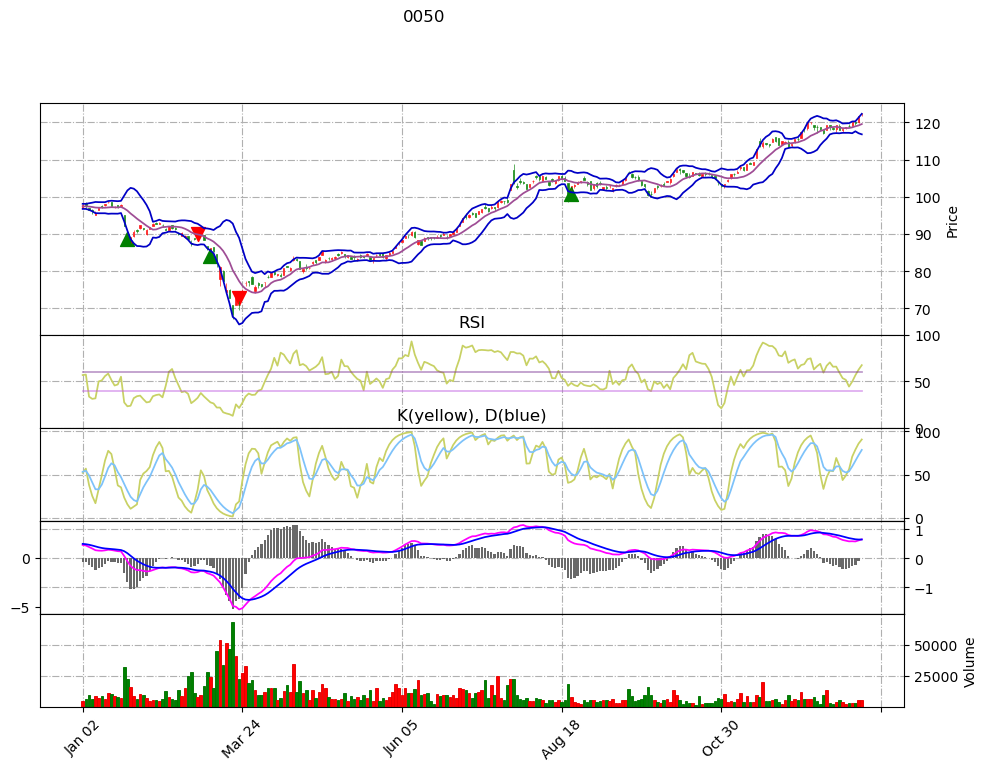

1605


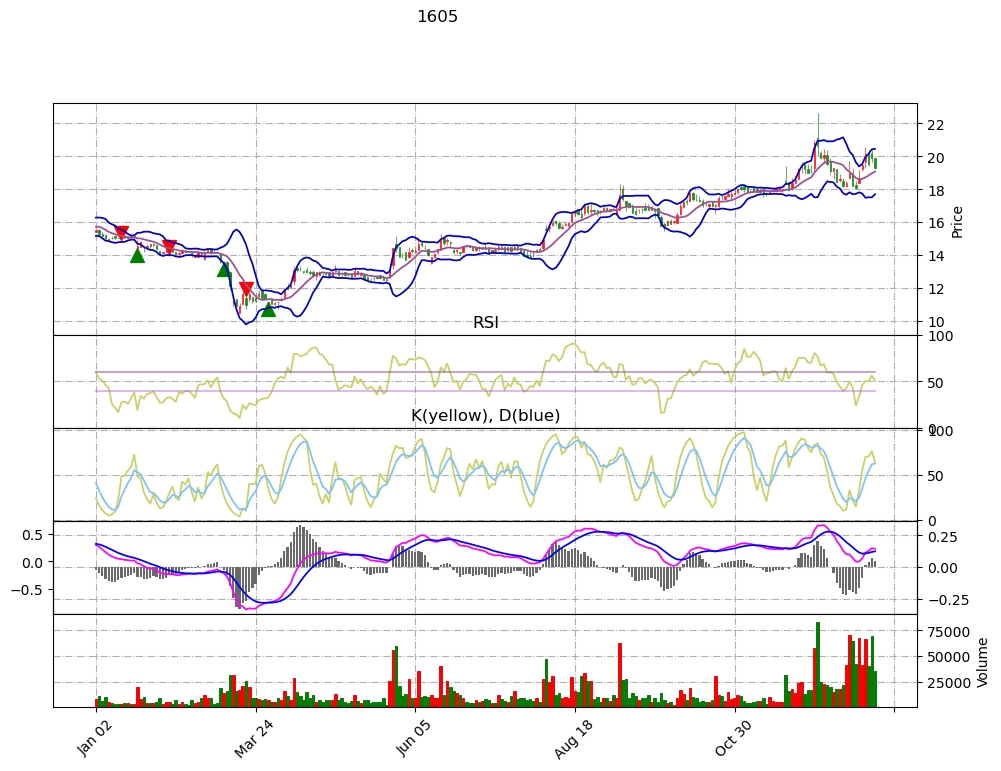

2301


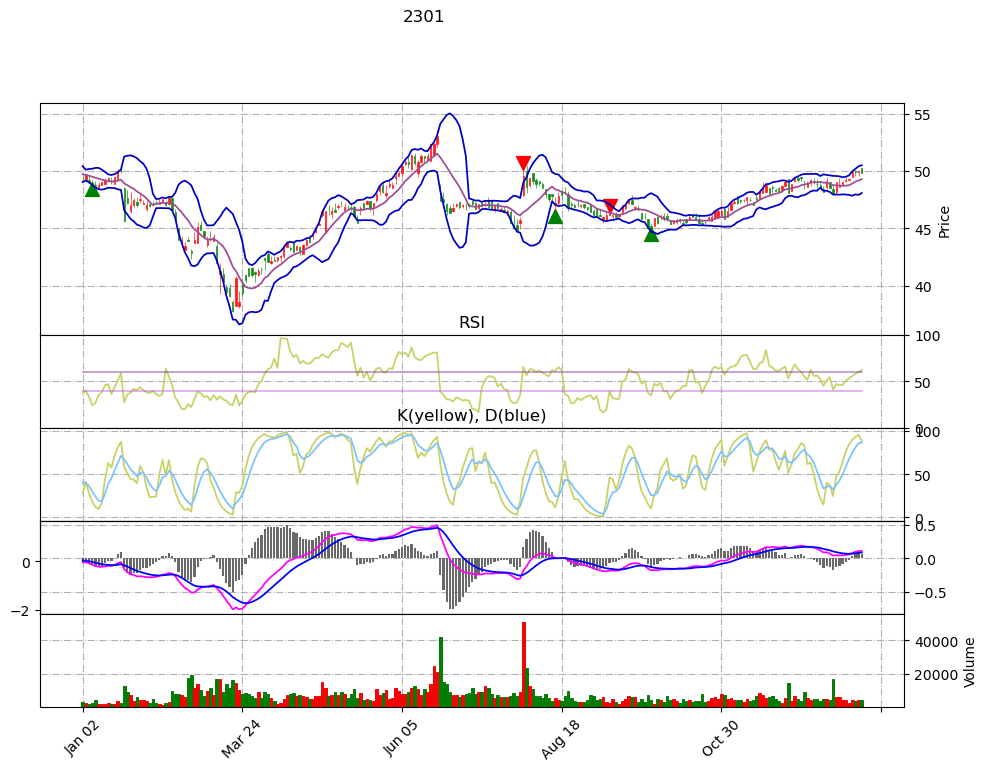

2303


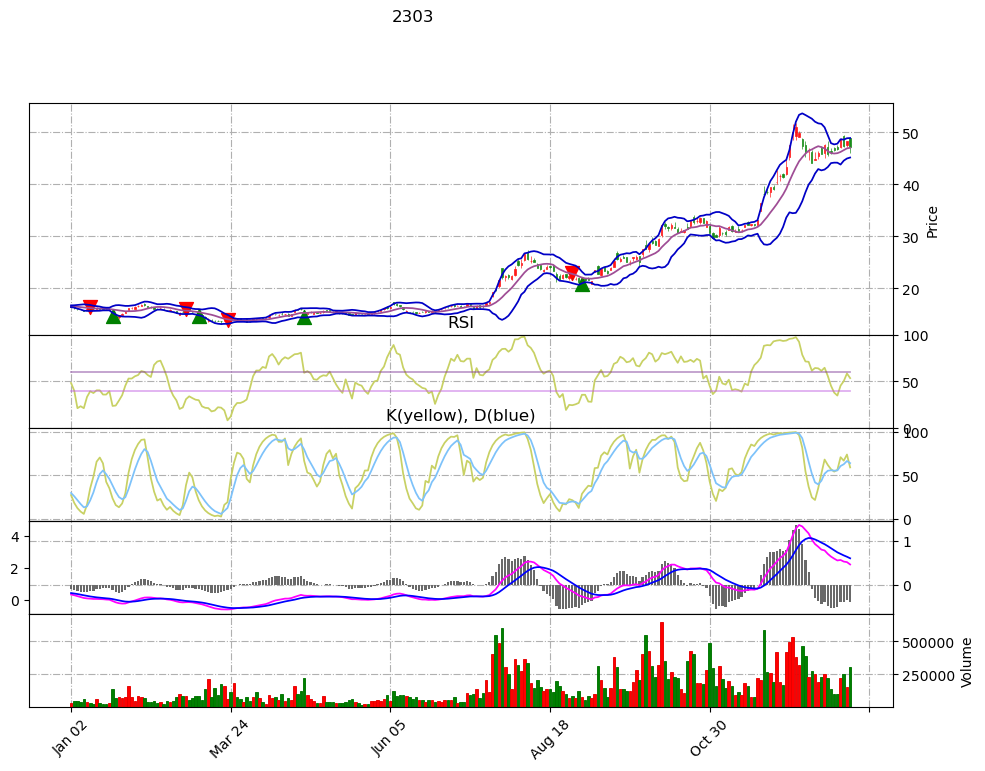

2317


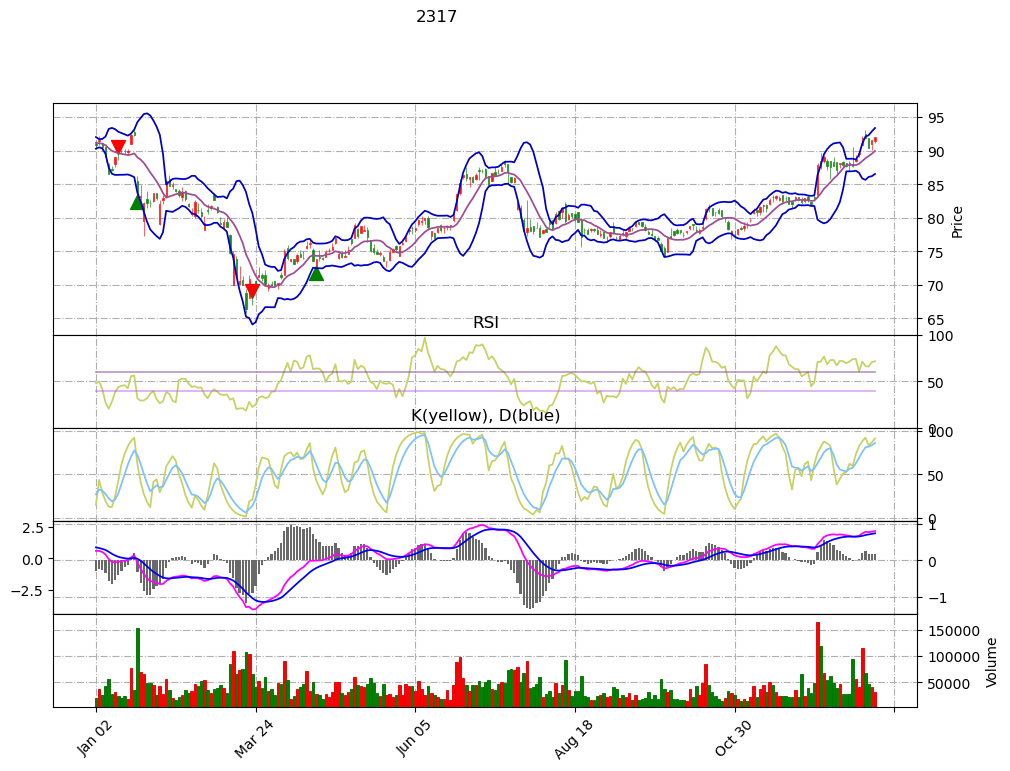

2330


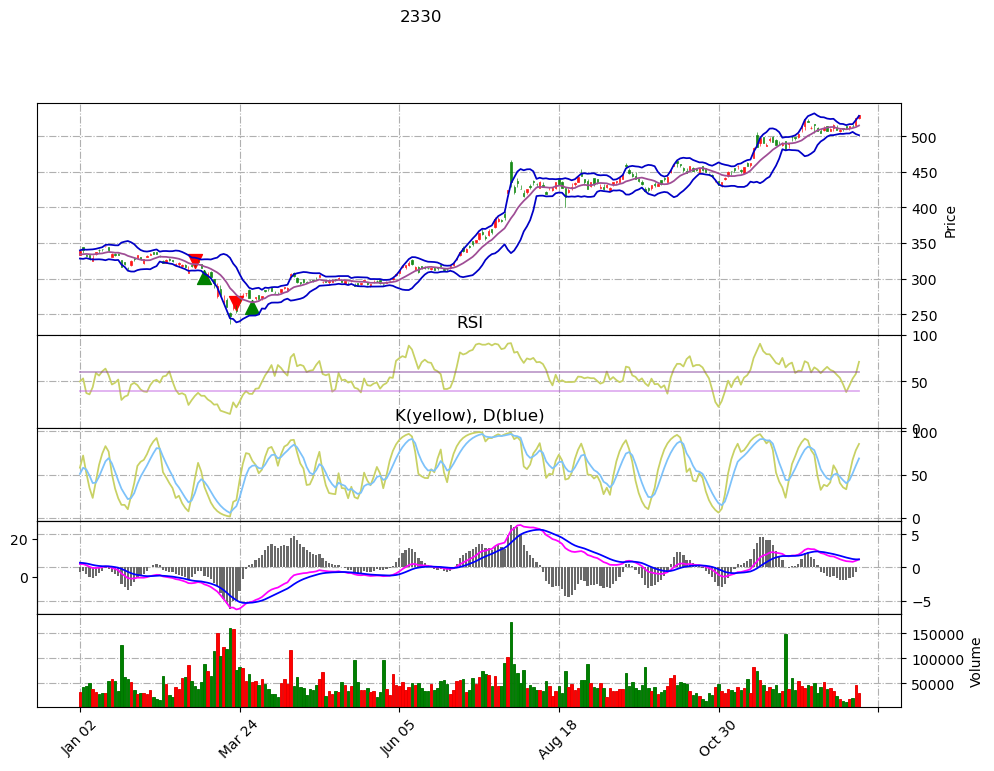

2352


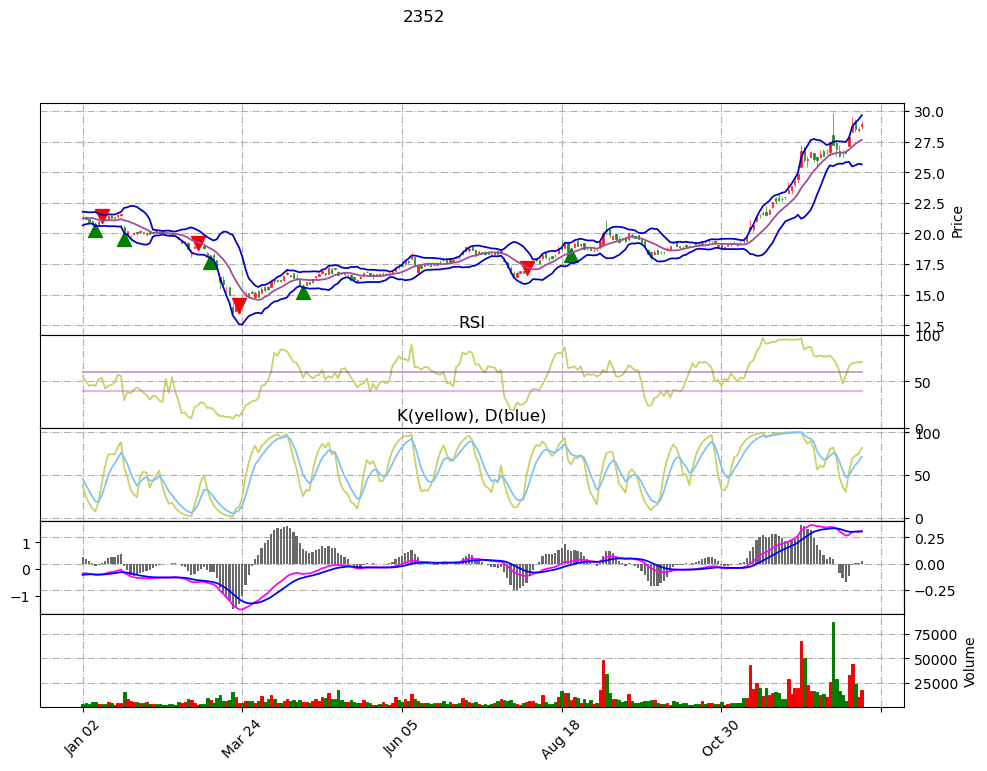

2409


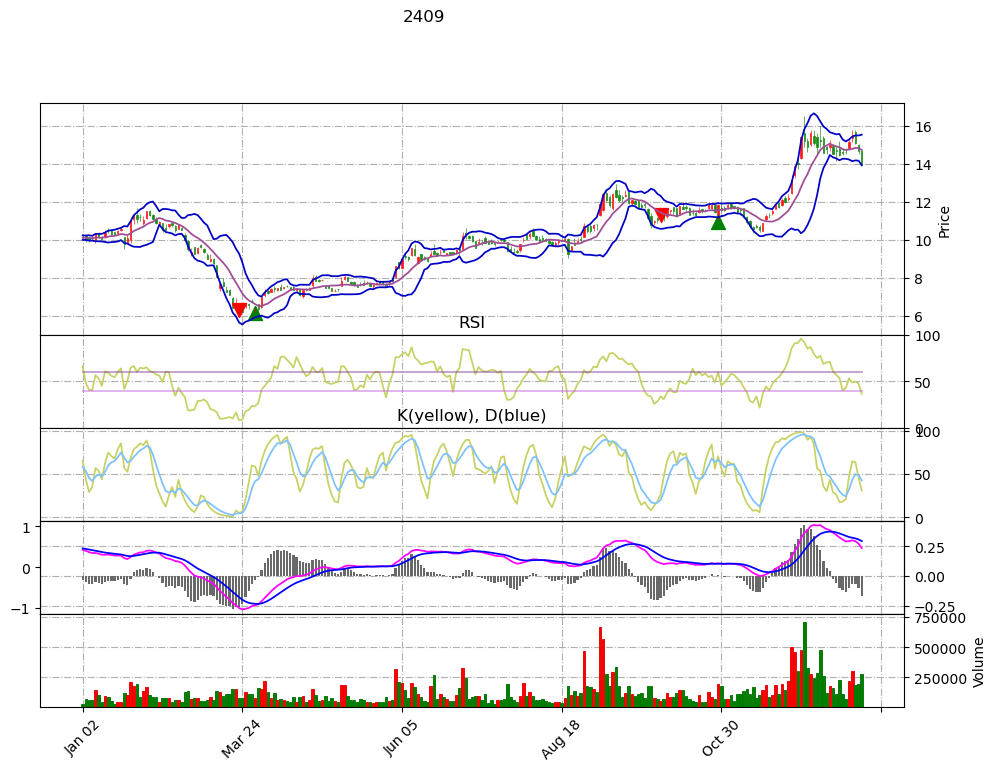

2449


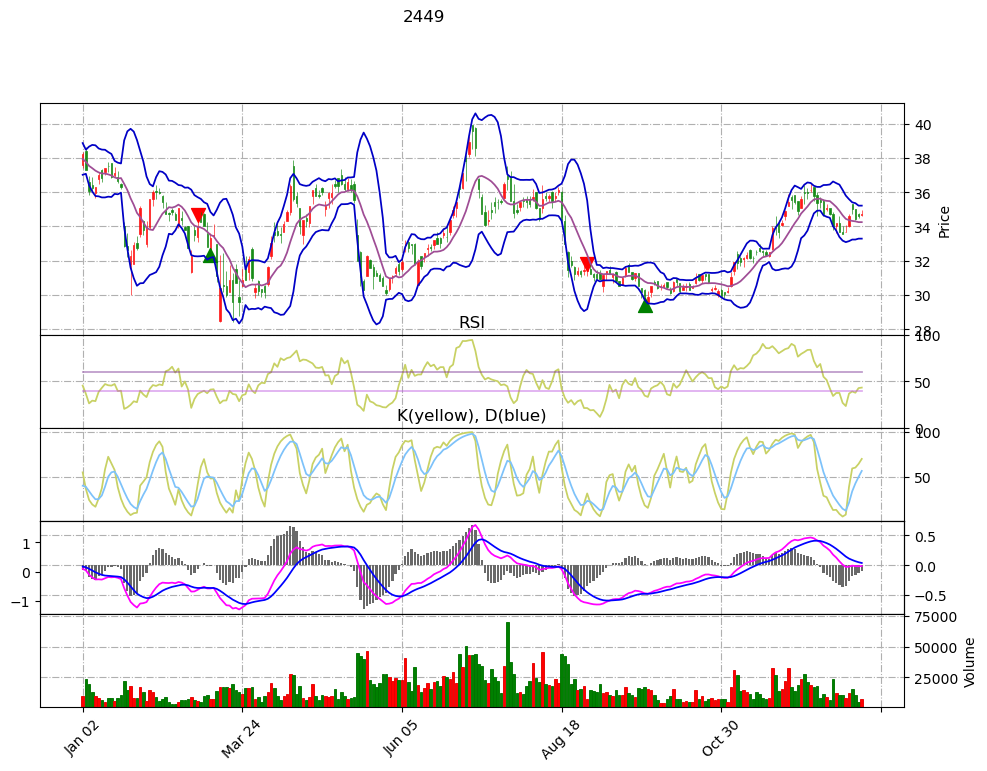

2454


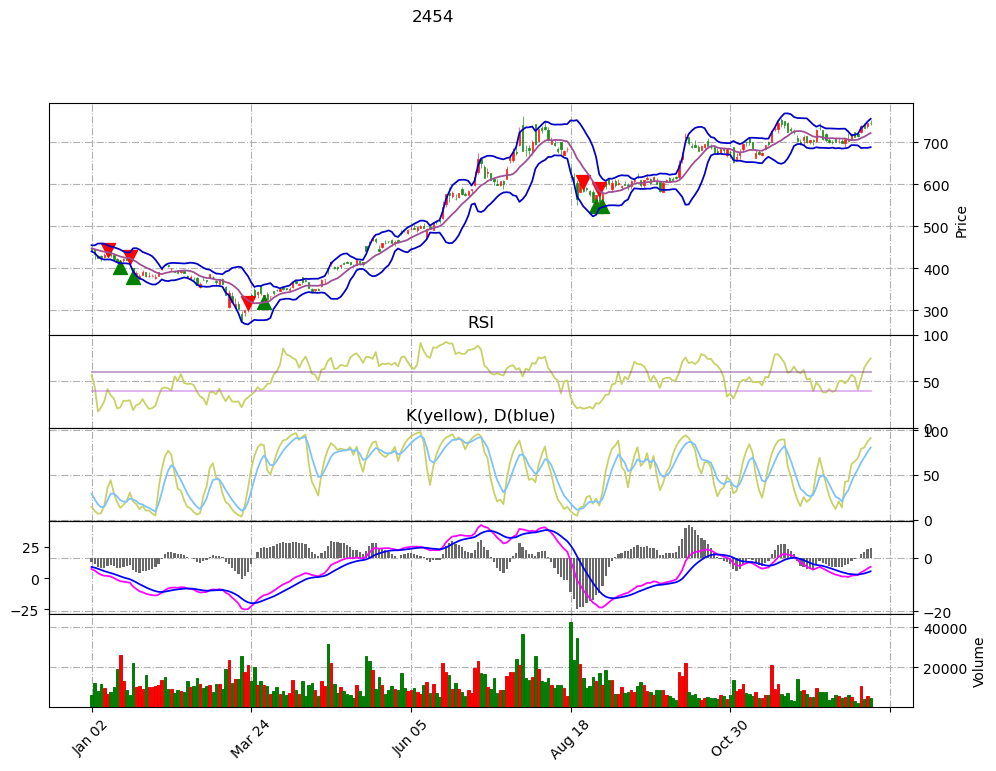

2609


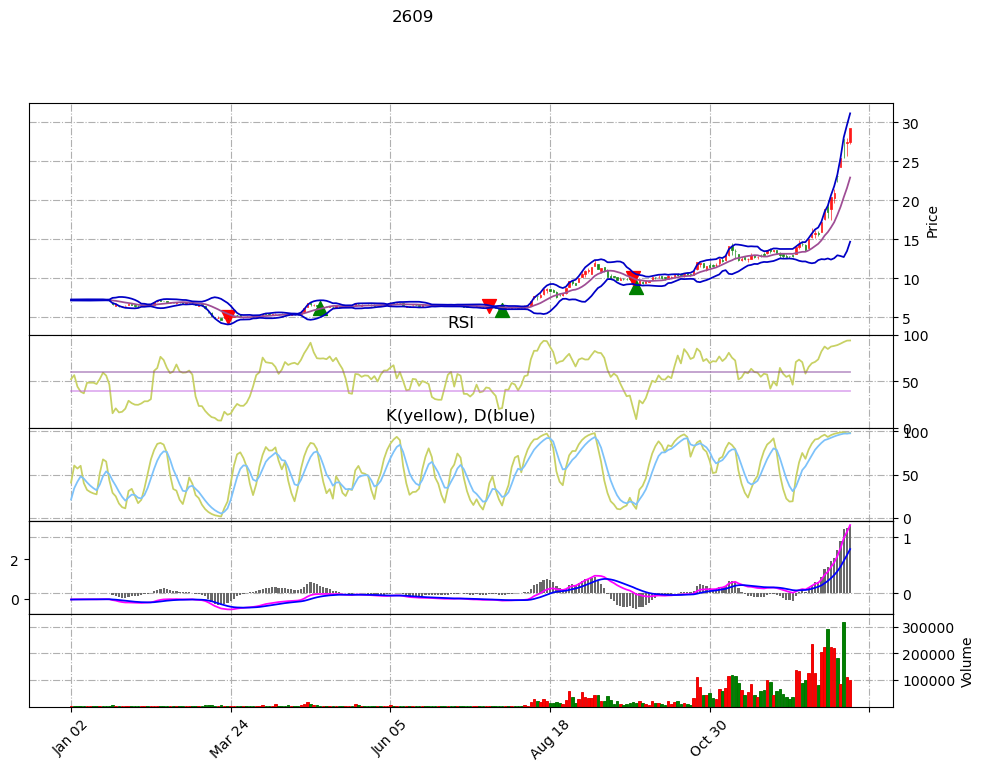

3481


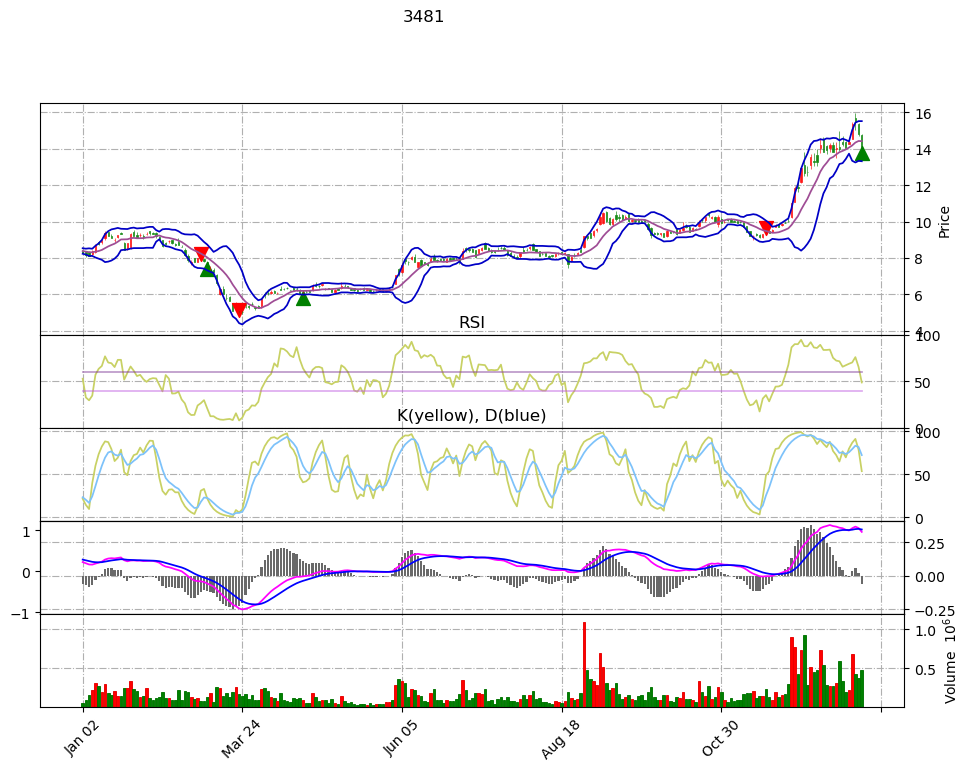

      Trades  Win  Loss  Win_Rate     Profit
0050       4    3     1  0.750000  49.462320
1605      12    4     8  0.333333  14.137448
2301       3    0     3  0.000000  -5.657155
2303       7    2     5  0.285714  -5.627968
2317       6    3     3  0.500000   3.452796
2330       5    2     3  0.400000  -5.136492
2352      10    6     4  0.600000  29.142208
2409      10    2     8  0.200000 -28.172555
2449       8    4     4  0.500000  -8.316166
2454       5    1     4  0.200000 -13.101307
2609      13    3    10  0.230769 -24.933553
3481      14    4    10  0.285714  35.350599


In [266]:
ticker_list = ['0050', '1605', '2301', '2303', '2317', '2330', '2352', '2409', '2449', '2454', '2609', '3481']
# strategy_list = [bound, ma_strategy, macd_rule_1]

# df_result = pd.DataFrame(columns=strategy_list)

res = []

for data in ticker_list:

    print(data)

    ticker = read_ticker(data)

    # calculate the indicator

    # ticker = MA(ticker, 5)
    # ticker = MA(ticker, 10)
    # ticker = MA(ticker, 20)
    # ticker = variation(ticker)
    ticker = RSI(ticker, 13)
    ticker = KD(ticker, 6)
    # ticker = TA_MACD(ticker)
    ticker = MACD(ticker)
    ticker = BBands(ticker)

    ticker = ticker.loc['2019-02':'2021-10', ]
    # ticker = macd_rule_1(ticker)
    ticker = muti_indi_rule_4(ticker)
    # ticker = kd_strategy(ticker)
    info = back_track_v3(ticker)


    df = ticker.merge(info, how='inner', left_index=True, right_index=True)
    # print(df.head())

    dff = df.loc['2020-01':'2020-12', ]
    plot_muti(dff, _title=data, volume=True, buy_sell_point=True, 
        RSI=True, rsi_midline=False, rsi_bound=True, rsi_upper_bound=60, rsi_lower_bound=40, 
        KD=True, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
        MACD=True, BBands=True)

    buy_info = get_trade_info(df)
    # print(buy_info)
    result = get_result(buy_info)
    # res.append(result)
    res += [result]
    # print(result)
    

res = pd.DataFrame(res)    
res.set_axis(ticker_list, axis='rows', inplace=True)
res.set_axis(['Trades', 'Win', 'Loss', 'Win_Rate', 'Profit'], axis='columns', inplace=True)

print(res)

## 單支股票，單個策略

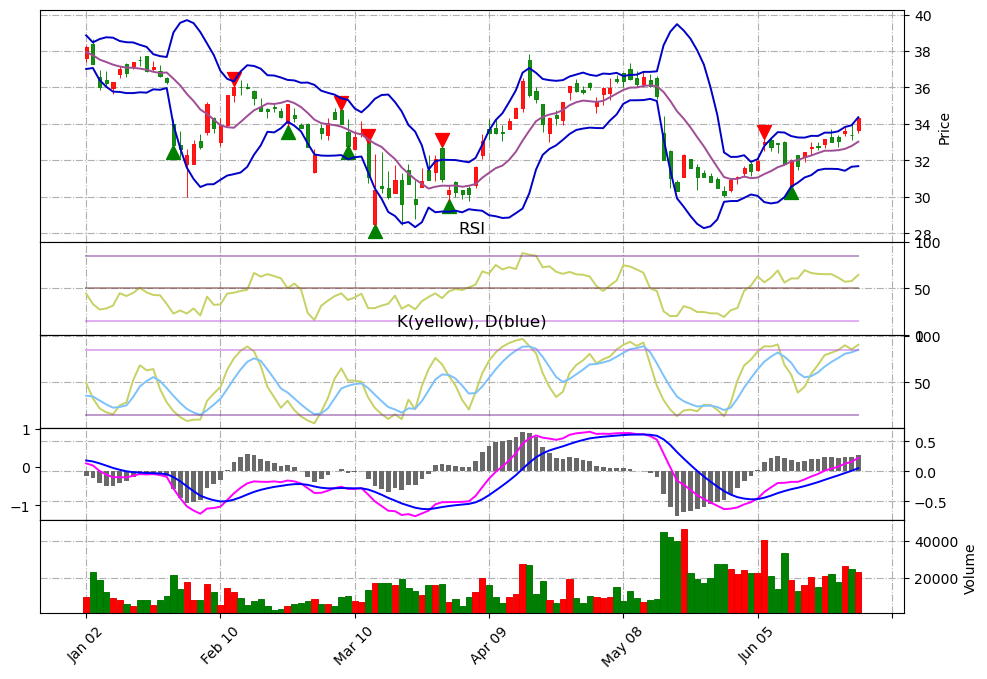

[26, 9, 17, 0.34615384615384615, -18.914068500000113]


In [253]:
ticker = read_ticker('2449')


# ticker = MA(ticker, 5)
# ticker = MA(ticker, 10)
# ticker = MA(ticker, 20)
# ticker = EMA(ticker, 20)
# ticker = TA_EMA(ticker, 20)
# ticker = variation(ticker)
ticker = BBands(ticker)
# ticker = TA_BBands(ticker)
ticker = RSI(ticker, 12)
ticker = KD(ticker, 7)
# ticker = TA_MACD(ticker)
ticker = MACD(ticker)
ticker = BBands(ticker)
# print(ticker.head())

ticker = ticker.loc['2019-02':'2022', ]

# 找買賣點
ticker = muti_indi_rule_5(ticker)

# 數據回測
info = back_track_v2(ticker)
df = ticker.merge(info, how='inner', left_index=True, right_index=True)
# print(df.head())

# 繪圖
dff = df.loc['2020-01':'2020-06', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=True, rsi_midline=True, rsi_bound=True, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=True, kd_bound=True, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=True, BBands=True)

data = get_trade_info(df)
# print(data)
result = get_result(data)
print(result)

data.to_csv('info_result.csv')
df.to_csv('result.csv')

# 最佳化單一策略

In [ ]:
# def test_to_best(funtion_name, rsi_max=20, rsi_min=5, kd_max=20, kd_min=5):

#     ticker_list = ['0050', '1605', '2301', '2303', '2317', '2330', '2352', '2409', '2449', '2454', '2609', '3481']

#     d1 = []

#     for rsi_n in range(rsi_min, rsi_max + 1):
        
#         d2 = []
#         for kd_n in range(kd_min, kd_max + 1):

#             res = 0
            
#             for data in ticker_list:

#                 ticker = read_ticker(data)
#                 print(data)
#                 # calculate the indicator
   
#                 ticker = RSI(ticker, rsi_n)
#                 ticker = KD(ticker, kd_n)
#                 ticker = MACD(ticker)

#                 ticker = ticker.loc['2019-02':'2021-10', ]
        
#                 ticker = funtion_name(ticker)
        
#                 info = back_track_v3(ticker)

#                 df = ticker.merge(info, how='inner', left_index=True, right_index=True)

#                 buy_info = get_trade_info(df)
#                 result = get_result(buy_info)
#                 print(result)
#                 res += result[4]
            
#             res /= len(ticker_list)

#             d2 += [res]
        
#         d1 += [d2]

#     print(d1)

#     return
    
# test_to_best(muti_indi_rule_2)
